<a href="https://colab.research.google.com/github/atuchiya/openmpw-transistor-level-examples/blob/main/jupyter-notebook/ADC/SAR_ADC_Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SAR-ADCってどういう回路？

SAR-ADC (逐次比較型 Analog-to-Digital Converter) は ADCの一種．
SAR は Successive Approximation Register の略です．Successive Approximation が逐次比較で，逐次比較をするために使う回路が Successive Approximation Register．
SAR-ADC はいろいろある ADC の中でも動作が簡単な上におそらく最もオールマイティに使える方式です．基本的な動作を勉強しましょう．

## そもそもADC って何だ

そもそもADC (Analog-to-Digital Converter) って…？ 名前の通りアナログ値 (電圧) をデジタル値 (バイナリコード) に変換する回路です．逆にデジタル値からアナログ電圧を生成する回路が DAC (Digital-to-Analog Converter)．ADC/DACを合わせて Data Converter と言ったりします．

回路図記号は下のもの．アナログ端子が尖っている方で、デジタル端子が平たい側です． アナログ端子に接続される配線は1本、デジタル側は1本に見えますが実際には1ビット1本の配線が必要なので複数の配線が接続されます．デジタル信号をアナログ信号に変換する DACの場合は右の記号で，形は同じで信号の方向が逆になります．
なお記号ではだいたい省略されますが実際にはクロック信号も必要です．

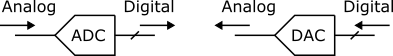

## ひとまず回路のことは置いておいて

回路は後で考えるとして，どうすればAD変換ができるか考えましょう．あと，Jupyter notebook に慣れてない人はこのあたりで慣れてください．まずは諸々準備のために次のコードを実行します．(これはただの準備で，実行しても特に何も表示されません．エラーが出なかったらOKです．)

In [1]:
# 定数の定義
VDD = 1.0

# 必要なものをインポートしておく
import numpy as np
import matplotlib.pyplot as plt

### 1ビットのAD変換 (コンパレータ)

1ビットのAD変換を考えます．アナログ入力に対して，1ビットのデジタル信号を出力します．つまり出力は 0 か 1 の二択．電源電圧の1/2 より上だったら 1，下だったら 0 を出力すればいいですね．この判定基準を参照電圧 Vref と呼ぶことにしましょう．ref は reference の略です．Python で書くと下のような感じです．実行すると結果と誤差が表示されます．アナログ入力電圧`a_in`の値を変えて試してみてください．

In [2]:
# アナログ入力電圧．ここの値を変えて試してみよう
a_in = 0.3

#======== ここから下は触らない ========#
# 参照電圧
vref = VDD / 2

# AD変換(？)
if a_in >= vref:
  d_out = 1
else:
  d_out = 0

# 結果の出力
print("analog input: {} V".format(a_in))
print("output code: {}".format(d_out))
print("coded voltage: {} V".format(VDD * d_out))
print("error: {} V".format(VDD * d_out - a_in))

analog input: 0.3 V
output code: 0
coded voltage: 0.0 V
error: -0.3 V


いやif文1つだけだし… という感じですが，これも一応 AD変換と言っていいでしょう．
入力された値 (analog input) とコードが表している電圧 (coded voltage) の誤差 (error) はまぁ大きいですが，1ビットしかないんだからしょうがない．

この，参照電圧と入力電圧を比較して，入力電圧大きかったら1，小さかったら0 を出力する という機能は使えそうな気がします．このような回路を**コンパレータ (comparator)**，日本語では**比較器**と呼びます．オペアンプにフィードバックかけずに使うとコンパレータとして動作しますね．後で使うので関数にしておきましょう．

In [3]:
# Comparator
def mycomp(vin, vref):
  if vin >= vref:
    d_out = 1
  else:
    d_out = 0

  return d_out

### 出力コードのビット数を増やす (分解能)

さすがに 0 か 1 かしか出さないというのはちょっと… という気がするのでちょっと出力コードを増やすことを考えましょう．
出力コードを $r$ビットにすると，出力コードは 0 から $2^r-1$ までの $2^r$通りの値を持つことができます．このビット幅 $r$ を**分解能 (resolution)**と呼びます．分解能10ビットなら1024階調というわけです．
アナログ値 (連続量) をビット列で表現する際，ビット列で表現された値は離散的な値になり，本来の値 (アナログ値) との間には必ず誤差 (**量子化誤差**) が生じます．分解能が増えるほど階調が多くなるので量子化誤差は減っていきます．分解能で階調の滑らかさと量子化誤差がどう変化するかを見てみましょう．だいたい分解能6ビットぐらいで人間の目ではほぼ判別できなくなります．この階段1段あたりの高さを 1 LSB と呼びます．LSB は Least Significant Bit の略で，最下位ビットのこと．つまり一番下のビットが変わったときに電圧がどのぐらい変わるか，というわけです．電源電圧を 1 V としているので，分解能 10ビットで1 LSB は 1 mVを切ります．

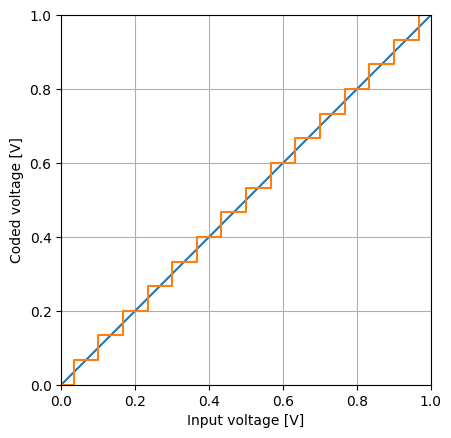

1 LSB = 62.5 mV


In [4]:
# 分解能の値を変えてみよう
res = 4

#======== ここから下は触らない ========#
plt.clf()

x1 = np.linspace(0, 1, 2**res)

ax = plt.axes()
ax.plot(x1, x1)
ax.step(x1, x1, where='mid')
ax.set_aspect('equal')
ax.grid()

ax.set_xlabel("Input voltage [V]")
ax.set_ylabel("Coded voltage [V]")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# plot
plt.show()

# LSB
print("1 LSB = {} mV".format(1000/2**res))

つまり AD変換はこの階段1段よりも高い精度で電圧を判別してビット列に直さないといけないというわけです．

今，手元にはコンパレータがあります．どうやって参照電圧を作るかは後で考えるとして，安直は方法としては「下から順番にしらみつぶし」が考えられます．
つまり参照電圧を0からちょっとずつ上げていくと，参照電圧が入力電圧を超えたところでコンパレータの出力は 1 から 0 に変わります．そのときの参照電圧が入力電圧と(だいたい) 等しいというわけです．コードで書くととっても単純．

In [ ]:
a_in = 0.78    # アナログ入力電圧 [V]
res = 10       # 分解能 [bit]

#======== ここから下は触らない ========#
for step in range(2**res):
  vref = VDD * step / 2**res
  if mycomp(a_in, vref) == 0:
    break

# output
print("analog input: {} V".format(a_in))
print("Vref: {} V".format(vref))
print("error: {:.2e} V".format(vref - a_in))
print("code: {:0{res}b}".format(step, res=res))
print("steps: {}".format(step))

analog input: 0.78 V
Vref: 0.7802734375 V
error: 2.73e-04 V
code: 1100011111
steps: 799


動きました．が，結果の最下段の steps の数字を見てください．これは答えに到達するまでに何回コンパレータが動いたかの数字です．分解能 (`res`) が大きく，かつアナログ入力 (`a_in`) が大きいとき，この steps の値が大きな数字になります．試しに分解能 16 bit とかにしてみましょう．

アナログ入力が 0 V～ VDD の間に均等に分布するとすると，この steps の期待値は分解能 $r$ bit に対して $2^{r-1}$，最悪の場合は `a_in` = VDD の場合で $2^r$回必要です．つまり**分解能に対して指数関数**でステップ数が増えていきます．ステップ数が増えると変換にかかる時間も増えるし消費電力も増える．これはちょっといただけない．

### 二分探索 (バイナリサーチ)

上でやったしらみつぶしは探索アルゴリズムで言うところの**線形探索 (linear search / sequential search)** で，計算量はデータ量 $n$ に比例します．$O(n)$ というわけです．最悪の計算量は「最後まで見つからない場合」なので $n$ です．分解能 $r$ で考えると $n=2^r$ なので計算量も最悪ケースも$r$の指数関数になってしまいます．

もう少し効率的な探索方法が**二分探索 (binary search)** です．探索空間を半分に割ってそのどちらに探索対象が含まれているかを判定する，というのを繰り返して対象を絞り込んでいくという方法で，計算量は $O(\log_2n)$，最悪でも $\lceil\log_2(n+1)\rceil$ 回で探索は終わります．つまり分解能 $r$ について言えば最悪でも $r$ 回で探索は終わります．指数関数とは雲泥の差．

※ $\lceil x\rceil$ は天井関数 (ceiling function) で，「$x$ を超える最小の整数」です．

探索アルゴリズムはリストの中から一致するものを探すもので，
AD変換は入力電圧に最も近い電圧になるバイナリコードを決める，という点で少し違います．探索の場合は対象を発見したらその時点で探索は終了ですが，AD変換ではバイナリコードをすべて定めるまで終了しませんので，ステップ数は常に最悪の $r$回となります．

### SAR-ADC を作ろう

SAR-ADC では探索空間が $r$ビットのビット列全体となるわけですが，
このビット列の空間というのが二分探索で非常に探索しやすい空間になっています．

二分探索では探索空間を半分にしていく，という操作を繰り返すため，参照電圧は
(電源電圧を 1 V とすると) 0.5 V → 0.75 V or 0.25 V → 0.875 V or 0.625 V or 0.375 V or 0.125 V → … と動きます．これをバイナリコードで書くと
10000 → 11000 or 01000 → 11100 or 10100 or 01100 or 00100 → … となります．つまり上 (MSB: 最上位桁) から順番に 0 か 1 決めていけばいいのです．下の図のように，まず VDD/2 (10000…) からスタートし，1回目の比較で MSB を 0 にするか 1 にするか決めます．次は上から2ビット目を1に変えます．最上位桁が1なら 11000… で 3/4，最上位桁が0なら 01000… で 1/4 になります．最上位桁から順に比較して値を決めていく，というのが逐次比較という方式です．

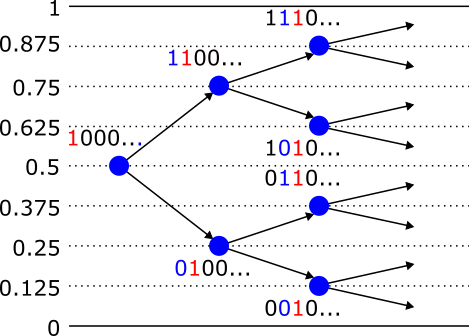



In [ ]:
# DA Converter
def mydac(c_list):
  code = ''.join(str(b) for b in c_list)
  value_dec = int(code, 2)
  return value_dec / 2**(len(c_list))


### SAR-ADC の動作

SAR-ADC は二分探索そのものなので，その動作をコードで書くと下のようになります．
AD変換を行なっている部分はわずか4行，構成要素は

* コンパレータ (`mycomp`)
* DA変換器 (`mydac`)
* コードのレジスタ (`code`) を更新する論理 (`for`，`if`)

の3つだけです．

入力電圧 `a_in` と分解能 `res` をいろいろ変えて試してみましょう．



In [ ]:
a_in = 0.723  # アナログ入力電圧 [V]
res = 14      # 分解能 [bit]

#======== ここから下は触らない ========#

# バイナリコードを 0 で初期化
code = [0] * res

# AD変換
for i in range(res):
  code[i] = 1
  if mycomp(a_in, mydac(code)) != 1:
    code[i] = 0

# 結果の出力
print("analog input: {} V".format(a_in))
print("resolution: {} bit".format(res))
print("output code: {}".format(''.join(str(b) for b in code)))
print("coded voltage: {} V".format(mydac(code)))
print("quantization error: {:.2e} V".format(mydac(code) - a_in))
print("steps: {}".format(res))


analog input: 0.723 V
resolution: 14 bit
output code: 10111001000101
coded voltage: 0.72296142578125 V
quantization error: -3.86e-05 V
steps: 14


コードをMSBから順番にLSBまで決めていくので，ステップ数は常に分解能 `res` に等しくなります．動作を可視化すると下のようになります．ステップが進むに従って値がアナログ入力に近づき，量子化誤差が減っていることが分かります．

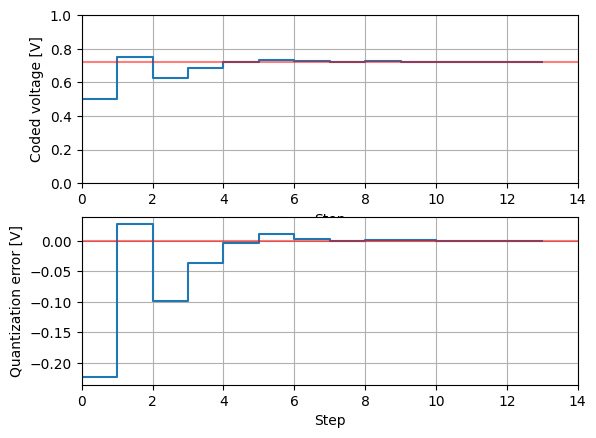

analog input: 0.723 V
resolution: 14 bit
output code: 10111001000101
coded voltage: 0.72296142578125 V
quantization error: -3.86e-05 V
steps: 14


In [ ]:
a_in = 0.723  # アナログ入力電圧 [V]
res = 14      # 分解能 [bit]

#======== ここから下は触らない ========#

# バイナリコードを 0 で初期化
code = [0] * res
dac_out = []  # DAC出力電圧
qerror = []   # 量子化誤差

# AD変換
for i in range(res):
  code[i] = 1
  dac_out.append(mydac(code))
  qerror.append(mydac(code) - a_in)
  if mycomp(a_in, mydac(code)) != 1:
    code[i] = 0

# グラフ表示
plt.clf()
ax1 = plt.subplot(2,1,1)
ax1.step(range(res), dac_out, where='post')
ax1.axhline(y=a_in, color='red', alpha=0.5)
ax1.grid()

ax1.set_xlabel("Step")
ax1.set_ylabel("Coded voltage [V]")
ax1.set_xlim(0, res)
ax1.set_ylim(0, 1)

ax2 = plt.subplot(2,1,2)
ax2.step(range(res), qerror, where='post')
ax2.axhline(y=0, color='red', alpha=0.5)
ax2.grid()

ax2.set_xlabel("Step")
ax2.set_ylabel("Quantization error [V]")
ax2.set_xlim(0, res)

plt.show()

# 結果の出力
print("analog input: {} V".format(a_in))
print("resolution: {} bit".format(res))
print("output code: {}".format(''.join(str(b) for b in code)))
print("coded voltage: {} V".format(mydac(code)))
print("quantization error: {:.2e} V".format(mydac(code) - a_in))
print("steps: {}".format(res))
あ

## ADCの性能

分解能の他にどういう性能指標があるかを見ていきます．

(以下作成中)